## Environment

In [49]:
import numpy as np

In [50]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [51]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [52]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t, 1
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    return idx, sampled[idx]

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward


In [53]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t, 1
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm, upper_bound[pulled_arm]


  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[a])) if len(self.rewards_per_arm[a]) > 0 else 1e3

## Simulation

In [54]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [55]:
# generic
T = 365                                # horizon of experiment
n_experiments = 500                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [56]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([0.15,0.1,0.1,0.35,0.1])             # bernoulli distributions for the reward functions
opt_rate = p[np.argmax(p*prices)]                 # optimal arm
print("Pricing (optimal price):")
print("idx: " + str(np.argmax(p*prices)) + "  price: " + str(prices[np.argmax(p*prices)]) + "  rate: " + str(opt_rate) + "  price*rate: " + str(opt_rate*prices[np.argmax(p*prices)]))

Pricing (optimal price):
idx: 3  price: 8  rate: 0.35  price*rate: 2.8


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768


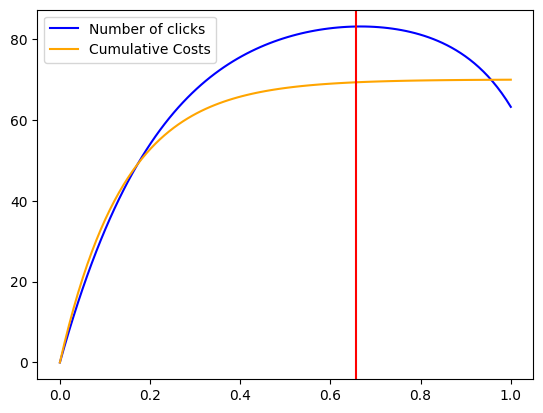

In [57]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid = bids[np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid,c='red')
print("Advertising (optimal bid):")
print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## Known advertising

In [58]:
# experiments
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  ts_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  ucb_learner = UCB_Pricing_Learner(n_arms = n_prices,
                                    prices = prices)


  ts_collected_costs = np.array([])
  ucb_collected_costs = np.array([])
  ts_daily_pricing_reward = np.array([])
  ucb_daily_pricing_reward = np.array([])

  curr_opt_ts = 1
  curr_opt_ucb = 1

  for t in range(0,T):  # cycle on time horizon

    # TS
    pulled_bid = np.argmax(curr_opt_ts*clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ts_collected_costs = np.append(ts_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price, curr_opt_ts = ts_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      ts_learner.update(pulled_price, reward_price)
    ts_daily_pricing_reward = np.append(ts_daily_pricing_reward,(reward_click>0)*np.sum(ts_learner.collected_rewards[-reward_click:]))


    # UCB
    pulled_bid = np.argmax(curr_opt_ucb*clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price, curr_opt_ucb= ucb_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      ucb_learner.update(pulled_price, reward_price)
    ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,(reward_click>0)*np.sum(ucb_learner.collected_rewards[-reward_click:]))


  ts_rewards_per_experiment.append(ts_daily_pricing_reward - ts_collected_costs)
  ucb_rewards_per_experiment.append(ucb_daily_pricing_reward - ucb_collected_costs)

100%|██████████| 500/500 [34:56<00:00,  4.19s/it]


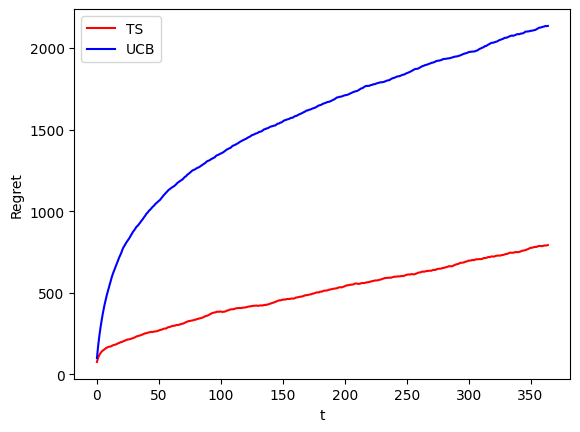

In [59]:
opt = opt_rate*prices[np.argmax(p*prices)]*clicks(opt_bid) - costs(opt_bid)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["TS", "UCB"])
plt.show()

In [60]:
#np.savetxt('part1_ts.txt',ts_rewards_per_experiment)
#np.savetxt('part1_ucb.txt',ucb_rewards_per_experiment)

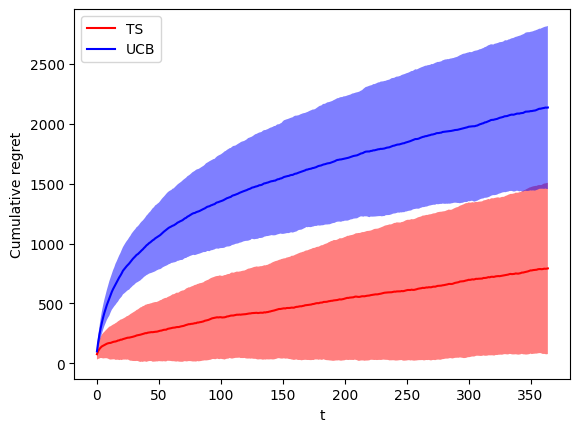

In [61]:
plt.figure()
plt.ylabel("Cumulative regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')

time = range(0, T)
ts_std = np.std(np.cumsum(opt - ts_rewards_per_experiment, axis=1), axis=0)
ts_metric= np.mean(np.cumsum(opt - ts_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(np.cumsum(opt - ucb_rewards_per_experiment, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(opt - ucb_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["TS", "UCB"])
plt.show()

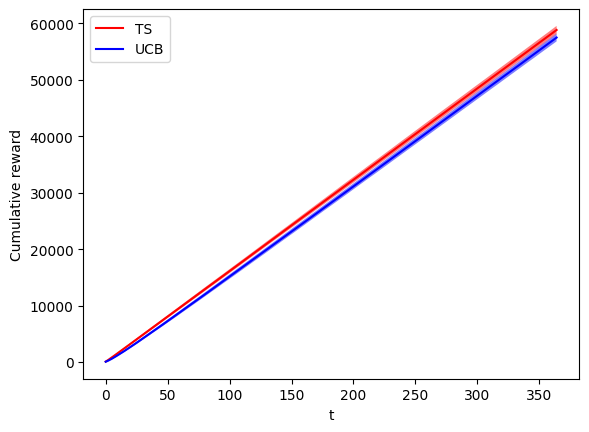

In [62]:
plt.figure()
plt.ylabel("Cumulative reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')

time = range(0, T)
ts_std = np.std(np.cumsum(ts_rewards_per_experiment, axis=1), axis=0)
ts_metric= np.mean(np.cumsum(ts_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(np.cumsum(ucb_rewards_per_experiment, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(ucb_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["TS", "UCB"])
plt.show()

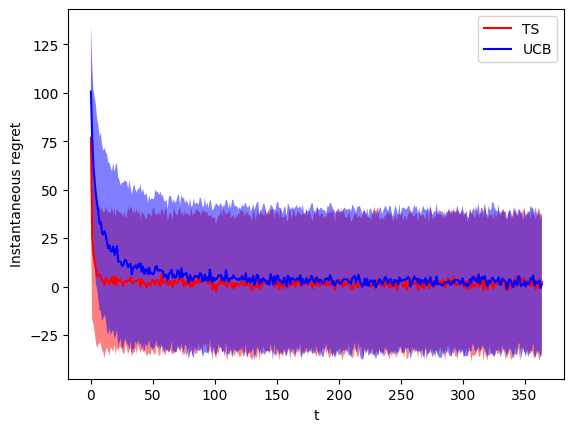

In [63]:
plt.figure()
plt.ylabel("Instantaneous regret")
plt.xlabel("t")
plt.plot(np.mean(opt - ts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(opt - ucb_rewards_per_experiment, axis=0), 'b')

time = range(0, T)
ts_std = np.std(opt - ts_rewards_per_experiment, axis=0)
ts_metric= np.mean(opt - ts_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(opt - ucb_rewards_per_experiment, axis=0)
ucb_metric = np.mean(opt - ucb_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["TS", "UCB"])
plt.show()

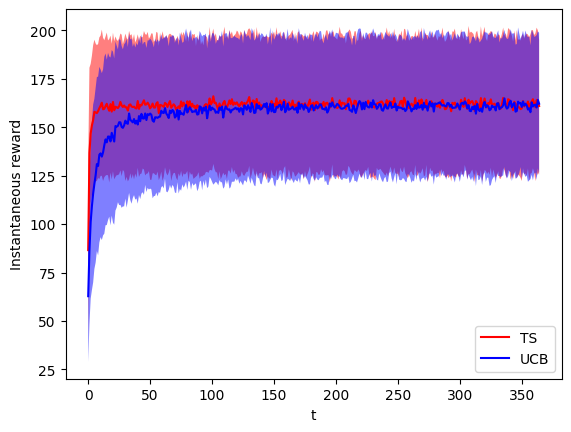

In [64]:
plt.figure()
plt.ylabel("Instantaneous reward")
plt.xlabel("t")
plt.plot(np.mean(ts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(ucb_rewards_per_experiment, axis=0), 'b')

time = range(0, T)
ts_std = np.std(ts_rewards_per_experiment, axis=0)
ts_metric= np.mean(ts_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(ucb_rewards_per_experiment, axis=0)
ucb_metric = np.mean(ucb_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["TS", "UCB"])
plt.show()